Importing Dependencies


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from tensorflow.keras.constraints import MinMaxNorm
import numpy as np
from numpy import random

from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
from tensorflow.keras.mixed_precision import experimental as mixed_precision

#format time into something more readable
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_policy(policy)

Defining Parameters

In [2]:
generate_res = (64,64)
PHOTO_PATH = "/kaggle/input/anime-faces/data/data"
DATA_PATH = "/kaggle/working/training_64_64.npy"#'/kaggle/input/animefacedataset/images'
MODEL_PATH = "/kaggle/working/"
SAVE_PATH = '/kaggle/working/'
SEED_SIZE = 128
BATCH_SIZE = 128
EPOCHS = 50 ## Increase this for better generated image 
img_width = 64
img_height = 64
channels = 3
n_critic = 5
learning_rate = 1e-4
beta1 = 0
beta2 = 0.9

First we'll need to convert the images to numpy arrays and store as training_64_64.npy

In [3]:
training_data = []
for filename in tqdm(os.listdir(PHOTO_PATH)):
    path = os.path.join(PHOTO_PATH,filename)
    image = Image.open(path).resize((img_width,
            img_height),Image.ANTIALIAS)
    training_data.append(np.asarray(image))
training_data = np.reshape(training_data,(-1,img_width,
            img_height,channels))
training_data = training_data.astype(np.float32)
training_data = training_data / 127.5 - 1 #images should be normalised to [-1,1]
print(np.shape(training_data))
np.save("training_64_64.npy",training_data) #This gets saved in /kaggle/working/

100%|██████████| 21551/21551 [00:56<00:00, 379.04it/s]


(21551, 64, 64, 3)


Define Generator Model

In [4]:
def build_generator(seed):
    model = Sequential()
    model.add(Conv2DTranspose(512, input_shape = (1,1,seed), kernel_size=4, strides=1, padding='valid',use_bias=False))
    model.add(Activation("relu"))
    
    #model.add(Dropout(0.5))
    model.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding='same',use_bias=False))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    #model.add(Dropout(0.5))
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same',use_bias=False))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    #model.add(Dropout(0.5))
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same',use_bias=False))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    #model.add(Dropout(0.5))
    model.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding='same',use_bias=False))
    model.add(Activation("tanh", dtype = 'float32'))
    model.summary()
    return model


Define Descriminator model

In [5]:
def build_discriminator(input_size):
    
    model = Sequential()

    model.add(Conv2D(64, kernel_size=4, strides=2, input_shape=input_size, padding="same"))
    #model.add(GaussianNoise(1))
    model.add(LeakyReLU(alpha=0.2))
    
    #model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=4, strides=2, padding="same",use_bias=False))
    #model.add(GaussianNoise(1))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    
    #model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=4, strides=2, padding="same",use_bias=False))
    #model.add(GaussianNoise(1))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    
    #model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=4, strides=2, padding="same",use_bias=False))
    #model.add(GaussianNoise(1))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    #model.add(Dropout(0.25))
    model.add(Conv2D(1, kernel_size=4, strides=1, padding="valid",use_bias=False))
    model.add(Flatten())
    model.add(Activation('linear', dtype = 'float32'))
    model.summary()
    return model



Loading saved images such that training_data % batch_size == 0


In [6]:
training_data = np.load(DATA_PATH)
train_dataset = tf.data.Dataset.from_tensor_slices(training_data[:int(len(training_data)/BATCH_SIZE)*BATCH_SIZE]).shuffle(int(len(training_data)/BATCH_SIZE)*BATCH_SIZE).batch(BATCH_SIZE)
training_data = []

Initializing generator and discriminator model

In [7]:
discriminator = build_discriminator((img_height,img_width,channels))#tf.keras.models.load_model("/kaggle/working/face_discriminator.h5")#
generator = build_generator(SEED_SIZE)#tf.keras.models.load_model("/kaggle/working/face_generator.h5")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131072    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         524288    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 512)         2

Define gen and disc loss as well as Adam optimizers

In [8]:
def discriminator_loss(real_output,fake_output,penalty):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output) + penalty

def generator_loss(seed):
    fake_images = generator(seed,training=True)
    fake_output = discriminator(fake_images,training=True)
    return -tf.reduce_mean(fake_output)

generator_optimizer = Adam(learning_rate,beta1,beta2) 
#generator_optimizer = mixed_precision.LossScaleOptimizer(generator_optimizer, loss_scale='dynamic')

discriminator_optimizer = Adam(learning_rate,beta1,beta2)
#discriminator_optimizer = mixed_precision.LossScaleOptimizer(discriminator_optimizer, loss_scale='dynamic')

Discriminator train dunction

In [9]:
@tf.function
def train_disc(real_images,seed):
    with tf.GradientTape() as disc_tape:
        
        fake_images = generator(seed,training=True)
        real_output = discriminator(real_images,training=True)
        fake_output = discriminator(fake_images,training=True)
        g_penalty = gradient_penalty(real_images,fake_images)
        disc_loss = discriminator_loss(real_output,fake_output,g_penalty)
        #scaled_disc_loss = discriminator_optimizer.get_scaled_loss(disc_loss)
        
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)#(scaled_disc_loss, discriminator.trainable_variables)
        #gradients_of_discriminator = discriminator_optimizer.get_unscaled_gradients(gradients_of_discriminator)
    
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return tf.reduce_mean(real_output),g_penalty

Function to calculate Gradient Penalty 

In [10]:
def gradient_penalty(real_images,fake_images):
    t = np.random.uniform(size=[BATCH_SIZE, 1, 1, 1], low=0., high=1.).astype("float32")
    penalty_images = t* fake_images + (1-t)* real_images
    penalty_output = discriminator(penalty_images,training=True)
    penalty_grads = tf.gradients(penalty_output, [penalty_images])[0]
    slopes = tf.sqrt(1e-8 + tf.reduce_sum(tf.square(penalty_grads), axis=[1, 2, 3]))
    gradient_penalty = tf.reduce_mean((slopes - 1.) ** 2)            
    gradient_penalty = gradient_penalty * 10
    
    return gradient_penalty


Generator train function


In [11]:
@tf.function
def train_gen(seed):
    with tf.GradientTape() as gen_tape:
        gen_loss = generator_loss(seed)
        
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)#(scaled_gen_loss, generator.trainable_variables)
        #gradients_of_generator = generator_optimizer.get_unscaled_gradients(gradients_of_generator) 
        
        #scaled_gen_loss = generator_optimizer.get_scaled_loss(gen_loss)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return tf.reduce_mean(gen_loss)

Training Loop


In [12]:
def train(dataset, epochs):
  start = time.time()
  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []
    penalty_list = []

    for i,image_batch in enumerate(dataset):
      seed = np.random.normal(size=[BATCH_SIZE,1,1, SEED_SIZE]).astype("float32")
      disc_loss, penalty = train_disc(image_batch,seed)
      disc_loss_list.append(disc_loss)
      penalty_list.append(penalty)

      
      if i % n_critic == 0:
        gen_loss = train_gen(seed)
        gen_loss_list.append(gen_loss)
       
      
    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)
    penalty = sum(penalty_list) / len(penalty_list)
    
    if epoch%20 == 0:
        
        generator.save(os.path.join(SAVE_PATH,"face_generator.h5"))
        discriminator.save(os.path.join(SAVE_PATH,"face_discriminator.h5"))

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, fake output={g_loss},real output={d_loss}, penalty = {penalty}, {hms_string(epoch_elapsed)}')
        

  elapsed = time.time()-start
  print (f'Training time: {(elapsed)}')

Run training save model

In [13]:
train(train_dataset,EPOCHS)
generator.save(os.path.join(SAVE_PATH,"face_generator.h5"))
discriminator.save(os.path.join(SAVE_PATH,"face_discriminator.h5"))
print(SEED_SIZE)

Epoch 1, fake output=-7.92943811416626,real output=167.44056701660156, penalty = 54.985130310058594, 0:00:23.89
Epoch 2, fake output=-3.940338611602783,real output=193.9137420654297, penalty = 69.2217025756836, 0:00:16.11
Epoch 3, fake output=-11.39401626586914,real output=210.32044982910156, penalty = 72.47277069091797, 0:00:15.90
Epoch 4, fake output=-29.39552116394043,real output=227.48928833007812, penalty = 72.10052490234375, 0:00:16.19
Epoch 5, fake output=-55.8782958984375,real output=245.45880126953125, penalty = 68.52742004394531, 0:00:16.42
Epoch 6, fake output=-76.85504913330078,real output=231.30796813964844, penalty = 53.56172561645508, 0:00:15.81
Epoch 7, fake output=-68.49180603027344,real output=200.51734924316406, penalty = 43.677703857421875, 0:00:15.79
Epoch 8, fake output=-68.20756530761719,real output=191.98728942871094, penalty = 40.379600524902344, 0:00:16.21
Epoch 9, fake output=-63.08382034301758,real output=179.96966552734375, penalty = 37.35933303833008, 0:00

Display Random generated image

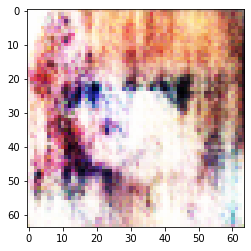

In [14]:
noise = tf.random.normal([1,1,1, 128])
generator = tf.keras.models.load_model(os.path.join(SAVE_PATH,"face_generator.h5"))
generated_image = generator.predict(noise)
generated_image = (generated_image + 1) * 127.5
plt.imshow(np.squeeze(generated_image).astype('uint8'))